# ROMS layer velocity plot

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

In [2]:
tidx = -1       # just get the final frame, for now.
scale = 0.03
isub = 3
url = 'http://geoport.whoi.edu/thredds/dodsC/examples/bora_feb.nc'

In [3]:
def shrink(a,b):
    """Return array shrunk to fit a specified shape by triming or averaging.
    
    a = shrink(array, shape)
    
    array is an numpy ndarray, and shape is a tuple (e.g., from
    array.shape). a is the input array shrunk such that its maximum
    dimensions are given by shape. If shape has more dimensions than
    array, the last dimensions of shape are fit.
    
    as, bs = shrink(a, b)
    
    If the second argument is also an array, both a and b are shrunk to
    the dimensions of each other. The input arrays must have the same
    number of dimensions, and the resulting arrays will have the same
    shape.
    Example
    -------
    
    >>> shrink(rand(10, 10), (5, 9, 18)).shape
    (9, 10)
    >>> map(shape, shrink(rand(10, 10, 10), rand(5, 9, 18)))        
    [(5, 9, 10), (5, 9, 10)]   
       
    """

    if isinstance(b, np.ndarray):
        if not len(a.shape) == len(b.shape):
            raise Exception, \
                  'input arrays must have the same number of dimensions'
        a = shrink(a,b.shape)
        b = shrink(b,a.shape)
        return (a, b)

    if isinstance(b, int):
        b = (b,)

    if len(a.shape) == 1:                # 1D array is a special case
        dim = b[-1]
        while a.shape[0] > dim:          # only shrink a
            if (dim - a.shape[0]) >= 2:  # trim off edges evenly
                a = a[1:-1]
            else:                        # or average adjacent cells
                a = 0.5*(a[1:] + a[:-1])
    else:
        for dim_idx in range(-(len(a.shape)),0):
            dim = b[dim_idx]
            a = a.swapaxes(0,dim_idx)        # put working dim first
            while a.shape[0] > dim:          # only shrink a
                if (a.shape[0] - dim) >= 2:  # trim off edges evenly
                    a = a[1:-1,:]
                if (a.shape[0] - dim) == 1:  # or average adjacent cells
                    a = 0.5*(a[1:,:] + a[:-1,:])
            a = a.swapaxes(0,dim_idx)        # swap working dim back

    return a

In [4]:
def rot2d(x, y, ang):
    '''rotate vectors by geometric angle'''
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)
    return xr, yr

In [5]:
nc = netCDF4.Dataset(url)
mask = nc.variables['mask_rho'][:]
lon_rho = nc.variables['lon_rho'][:]
lat_rho = nc.variables['lat_rho'][:]
anglev = nc.variables['angle'][:]

u = nc.variables['u'][tidx, -1, :, :]
v = nc.variables['v'][tidx, -1, :, :]

u = shrink(u, mask[1:-1, 1:-1].shape)
v = shrink(v, mask[1:-1, 1:-1].shape)

u, v = rot2d(u, v, anglev[1:-1, 1:-1])

In [6]:
lon_c = lon_rho[1:-1, 1:-1]
lat_c = lat_rho[1:-1, 1:-1]


/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):
-c:4: RuntimeWarning: invalid value encountered in sqrt


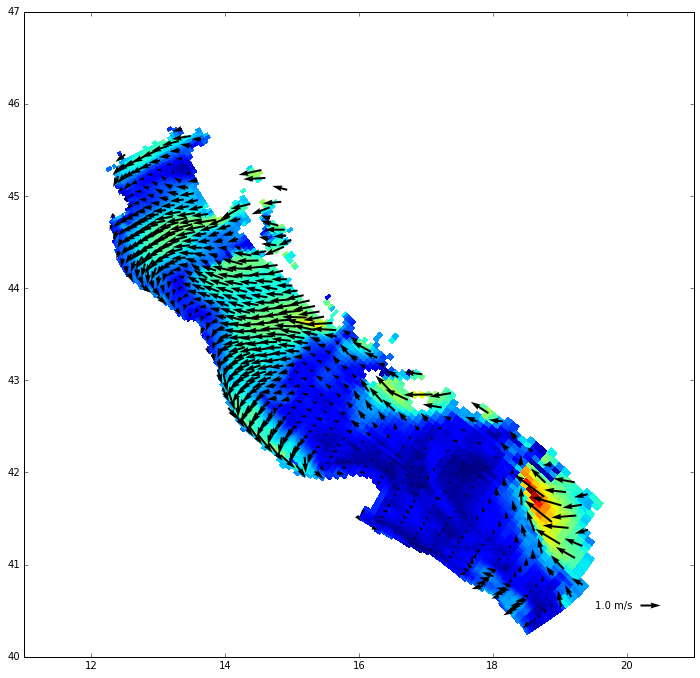

In [7]:
legend_vel=1.0
f = plt.figure(figsize=(12,12))
plt.subplot(111,aspect=(1.0/np.cos(np.mean(lat_c)*np.pi/180.0)))
plt.pcolormesh(lon_c,lat_c,np.sqrt(u*u + v*v))
Q = plt.quiver( lon_c[::isub,::isub], lat_c[::isub,::isub], u[::isub,::isub], v[::isub,::isub], 
        scale=1.0/scale, pivot='middle', zorder=1e35, width=0.003)
legend_str='%3.1f m/s' % legend_vel
qk = plt.quiverkey(Q,0.92,0.08,legend_vel,legend_str,labelpos='W')